In [6]:
from tensorflow.python.layers.core import dense
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/c9/bc/b7db44f5f39f9d0494071bddae6880eb645970366d0a200022a1a93d57f5/pip-25.0.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 259.2 kB/s eta 0:00:07
    --------------------------------------- 0.0/1.8 MB 245.8 kB/s eta 0:00:08
   - -------------------------------------- 0.1/1.8 MB 326.1 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.8 MB 479.3 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/1.8 MB 508.4 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/1.8 MB 653.6 kB/s eta 0:00:03
   -------- ------------------------------- 0.4/1.8 MB 1.0 MB/s 

ERROR: To modify pip, please run the following command:
C:\Users\asing\PycharmProjects\Deep_Face_Recognition\.venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!C:\Users\asing\PycharmProjects\Deep_Face_Recognition\.venv\Scripts\python.exe -m pip install --upgrade pip



  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/c9/bc/b7db44f5f39f9d0494071bddae6880eb645970366d0a200022a1a93d57f5/pip-25.0.1-py3-none-any.whl.metadata
  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [10]:
!pip install tensorflow opencv-python matplotlib

In [6]:
#importing standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
#importing tensorflow dependencies -Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [8]:
gpus= tf.config.experimental.list_physical_devices('GPU')
len(gpus)

0

In [9]:
#Setup Paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [26]:
#Make Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [10]:
#unzip and uncompress Tar GZ Labelled Faces in the Wild Dataset
import zipfile

# Unzipping the file
zip_path = "lfw-funneled.tgz.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")  # Extract to the current directory

import tarfile

# Extracting the tar file
tgz_path = "lfw-funneled.tgz"
with tarfile.open(tgz_path, 'r:gz') as tar_ref:
    tar_ref.extractall(".")  # Extract to the current directory


FileNotFoundError: [Errno 2] No such file or directory: 'lfw-funneled.tgz.zip'

In [33]:
#move lfw to following repository data/negative
for directory in os.listdir('lfw_funneled'):
    dir_path = os.path.join('lfw_funneled', directory)

    # ✅ Only process directories (skip files like pairs.txt)
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            EX_PATH = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [128]:
#import uuid Library to generate unique images names
import uuid

In [129]:
uuid.uuid1()

UUID('8306a4eb-f71f-11ef-b331-782b46742dcb')

In [132]:
#establishing a connection to the webcam
cap= cv2.VideoCapture(2)
while cap.isOpened():
    ret, frame = cap.read()

    #cut frame in 250X250 pixels
    frame =frame[120:120+250,230:230+250, :]

    #collects anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname= os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname= os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #show image back to screen
    cv2.imshow('Image Collection', frame)

    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

#Release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

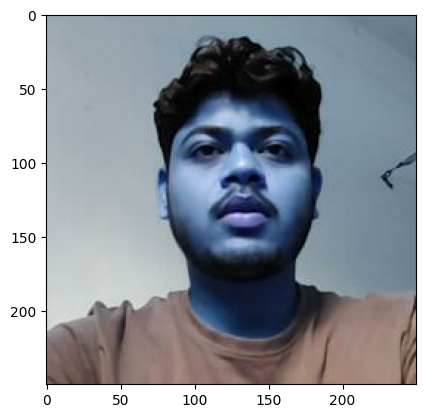

In [149]:
plt.imshow(frame)

In [150]:
frame.shape

(250, 250, 3)

In [151]:
frame[:250, :250, :].shape

(250, 250, 3)

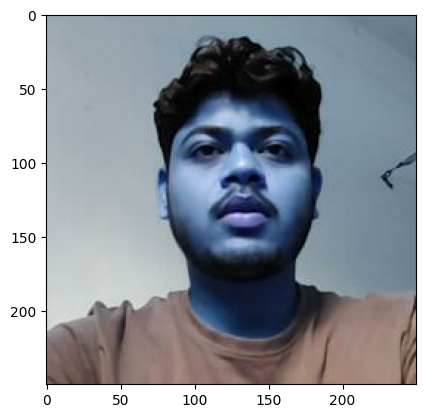

In [152]:
plt.imshow(frame[:250, :250, :])

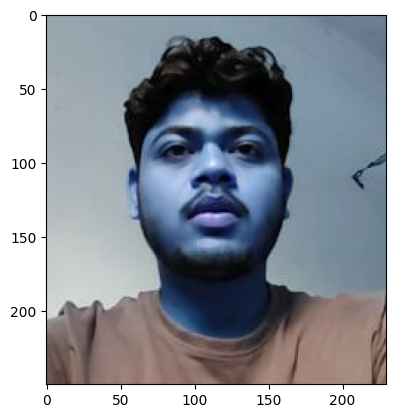

In [148]:
#its giving only top left corner so twik the slicing to get face in the frame
plt.imshow(frame[:250,20:200+250, :])

# LOADING AND PREPROCESSING IMAGES

In [154]:
#GET IMAGE DIRECTORIES
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(1000)
positive =tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(1000)
negative =tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(1000)

In [155]:
dir_test =anchor.as_numpy_iterator()

In [156]:
print(dir_test.next())

b'data\\anchor\\b95b6958-f71f-11ef-b13b-782b46742dcb.jpg'


In [157]:
#scaling and resizing
def preprocess(file_path):

    #reading image from the file path
    byte_img =tf.io.read_file(file_path)
    #loading the image
    img = tf.io.decode_jpeg(byte_img)

    #Preprocessing steps -resizing the image to be 100X100X3
    img =tf.image.resize(img, [100, 100])
    #Scaling image to be between 0 and 1
    img =img/255.0
    return img

In [158]:
img =preprocess('data\\anchor\\b95b6958-f71f-11ef-b13b-782b46742dcb.jpg')

In [159]:
img.numpy().min()

np.float32(0.0)

In [160]:
img.numpy().max()

np.float32(0.9857843)

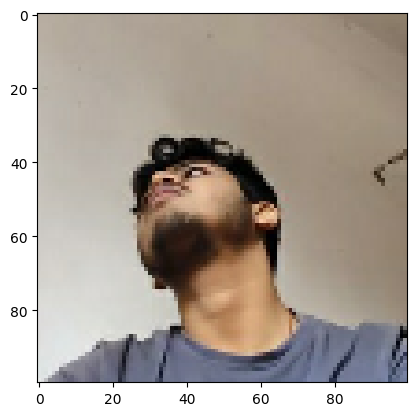

In [161]:
plt.imshow(img)

In [162]:
# Create Labelled Dataset
#(anchor, positive) => 1,1,1,1,1
#(anchor, positive) => 0,0,0,0,0
tf.ones_like([1,1,1,4,35235, 2352.5])

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1.], dtype=float32)>

In [163]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data =positives.concatenate(negatives)


In [164]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [165]:
samples =data.as_numpy_iterator()

In [166]:
example =samples.next()

In [167]:
example

(b'data\\anchor\\bc4dd6c5-f71f-11ef-a4b9-782b46742dcb.jpg',
 b'data\\positive\\e71c1f18-f71f-11ef-ac92-782b46742dcb.jpg',
 np.float32(1.0))

In [168]:
#Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [169]:
res =preprocess_twin(*example)

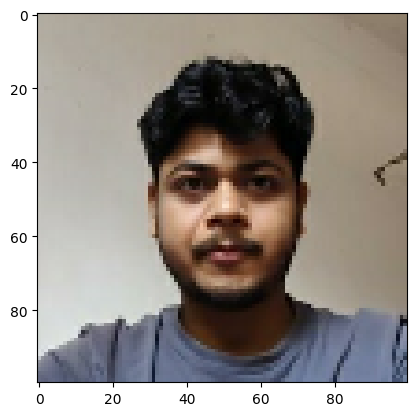

In [170]:
plt.imshow(res[1])

In [171]:
res[2]

np.float32(1.0)

In [172]:
#Build dataloader pipeline
data =data.map(preprocess_twin)
data =data.cache()
data =data.shuffle(buffer_size=1024)

In [173]:
samples =data.as_numpy_iterator()

In [174]:
len(samples.next())

3

In [184]:
samp =samples.next()

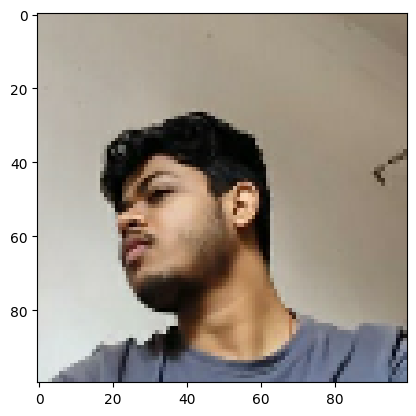

In [185]:
plt.imshow(samp[0])

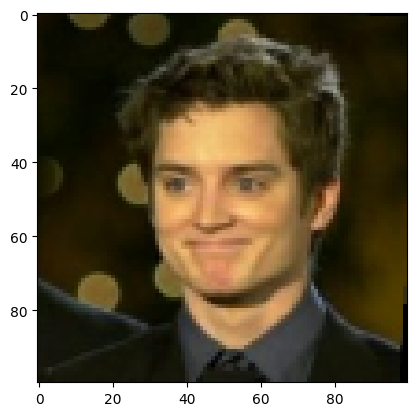

In [186]:
plt.imshow(samp[1])

In [187]:
samp[2]

np.float32(0.0)

In [188]:
round(len(data)*.7)

1400

In [189]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [191]:
#Training Partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [192]:
train_samples =train_data.as_numpy_iterator()

In [193]:
train_samples =train_samples.next()

In [194]:
len(train_samples[0])

16

In [195]:
round(len(data) * 0.3)

600

In [196]:
# Testing Partition
test_data = data.skip(round(len(data) * 0.7))
test_data =test_data.take(round(len(data) * 0.3))
test_data =test_data.batch(16)
test_data =test_data.prefetch(8)

# Model Engineering

In [197]:
#Building Layers
def make_embedding():
    inp =Input(shape=(100, 100, 3), name='input_image')

     #first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 =MaxPooling2D(64, (2,2), padding='same')(c1)

    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 =MaxPooling2D(64, (2,2), padding='same')(c2)

    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 =MaxPooling2D(64, (2,2), padding='same')(c3)

    #final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp, outputs=d1, name='embedding')

In [198]:
embedding = make_embedding()

In [199]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
# Building Distance Layer
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    #Similarity Calculations
    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [201]:
#Make Siamese Model
def make_siamese_model():

    # Anchor image input in network
    input_image = Input(shape=(100, 100, 3), name='input_img')

    # Validation image in the network
    validation_image = Input(shape=(100, 100, 3), name='validation_img')

    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])

    #Classification Layer - is input ans validation is same or not
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [202]:
siamese_model = make_siamese_model()

In [203]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [204]:
# Setup Loss and Optimizer
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [205]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [206]:
# Establishing checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [207]:
#Build Train Steps Function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #get anchor and positive/negative image
        X = batch[:2]
        #get label
        y = batch[2]

        #Forward Pass
        yhat = siamese_model(X, training=True)
        #Calculate Loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    #Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [208]:
#Building Training Loop
def train(data, EPOCHS):
    #Loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        #Loop through each batch
        for idx,batch in enumerate(data):
            #Run train step here
            train_step(batch)
            progbar.update(idx+1)

        #Saving Checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [209]:
#Training the Model
EPOCHS = 50

In [210]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
87/88 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
88/88 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step

 Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step

 Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step

 Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step

 Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step

 Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step

 Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step

 Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step

 Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step

 Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step

 Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step

 Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step

 Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step

 Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step

 Epoch 15/5

# Evaluating Model

In [211]:
#Impoting Metric Calculation
from tensorflow.keras.metrics import Precision, Recall

In [212]:
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [213]:
#Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00],
       [2.3567372e-09],
       [1.9844654e-13],
       [1.0000000e+00],
       [2.0494165e-13],
       [7.3142221e-11],
       [9.9984229e-01],
       [1.0454068e-13],
       [1.0000000e+00],
       [1.5795682e-11],
       [2.5597208e-10],
       [1.0000000e+00],
       [6.9880240e-13],
       [9.9999744e-01],
       [9.9998891e-01],
       [1.3368026e-09]], dtype=float32)

In [214]:
#Post processing the results
[1 if prediction >= 0.5 else 0 for prediction in y_hat]

[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]

In [215]:
y_true

array([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [216]:
#Creating a metric object
m= Precision()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return / recall Result
m.result().numpy()

np.float32(1.0)

In [217]:
#Creating a metric object
m= Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return / recall Result
m.result().numpy()

np.float32(1.0)

### vizualising Results

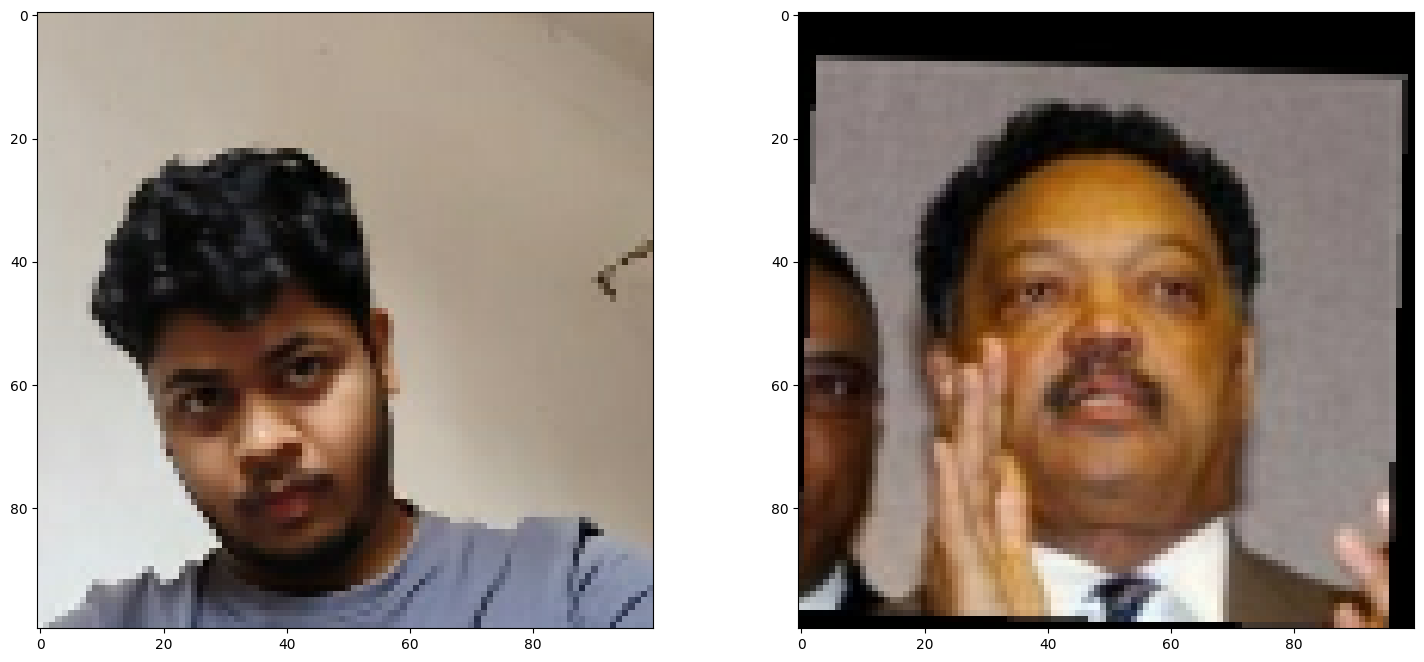

In [220]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[5])
plt.subplot(1,2,2)
plt.imshow(test_val[5])
plt.show()

# Saving our Model


In [221]:
#Save weights
siamese_model.save('siamesemodel.h5')

In [222]:
#Re-load model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [223]:
#Make prediction with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00],
       [2.3567372e-09],
       [1.9844654e-13],
       [1.0000000e+00],
       [2.0494165e-13],
       [7.3142221e-11],
       [9.9984229e-01],
       [1.0454068e-13],
       [1.0000000e+00],
       [1.5795682e-11],
       [2.5597208e-10],
       [1.0000000e+00],
       [6.9880240e-13],
       [9.9999744e-01],
       [9.9998891e-01],
       [1.3368026e-09]], dtype=float32)

In [224]:
#View reloaded model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real Time Test

## verification function

In [225]:
def verify(model, detection_threshold, verification_threshold):
    #Build results array
    results =[]
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        #Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    #Detection Threshold : Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    #Verification Threshold : Portion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

 ## OpenCV Real Time Verification

In [245]:
cap =cv2.VideoCapture(0)
while cap.isOpened():
    rat, frame = cap.read()
    #cut frame in 250X250 pixels
    frame =frame[120:120+250,230:230+250, :]

    cv2.imshow('Verifiaction', frame)

    #Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.3)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [238]:
np.sum(np.squeeze(results) > 0.7)

np.int64(30)

In [239]:
30/50

0.6